In [1]:
import pandas as pd
import pandahouse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib
import swifter
from scipy import stats
%matplotlib inline

Задача: применить метод линеаризации для оценки метрики CTR.

Проанализировать разницу между группами:
- 0 и 3  
- 1 и 2  
по метрике линеаризованных лайков.

Суть метода:
Вычислить общий CTR в контрольной группе и посчитать поюзерную метрику:
Затем сравнить группы с помощью t-теста по новой метрике.
Сравнить полученные p-value с результатами анализа обычного CTR.

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250220'
}

In [18]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-01-31' and '2025-02-06'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


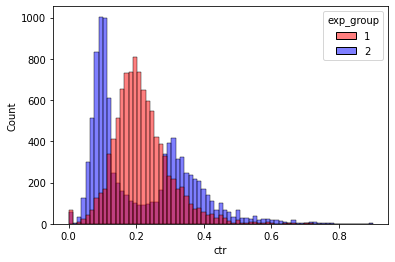

In [21]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [22]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [23]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

In [24]:
ctr_control = df[df.exp_group == 1]['likes'].sum() / df[df.exp_group == 1]['views'].sum()

#Добавляем новую метрику "линеаризованные лайки"
df['linearized_likes'] = df['likes'] - ctr_control * df['views']

In [25]:
df['linearized_likes']

0        -0.144062
1         2.445813
2         2.698896
3         9.445813
4         0.292667
           ...    
19892   -16.330957
19893    -1.366646
19894    15.380271
19895     8.406229
19896    -8.187541
Name: linearized_likes, Length: 19897, dtype: float64

In [26]:
t_stat, p_value = stats.ttest_ind(df[df.exp_group == 1]['linearized_likes'], 
                                  df[df.exp_group == 2]['linearized_likes'], 
                                  equal_var=False)

print(f"T-test p-value (linearized likes): {p_value}")

T-test p-value (linearized likes): 2.9805064038668164e-09


In [27]:
t_stat_ctr, p_value_ctr = stats.ttest_ind(df[df.exp_group == 1]['ctr'], 
                                          df[df.exp_group == 2]['ctr'], 
                                          equal_var=False)

print(f"T-test p-value (original CTR): {p_value_ctr}")

T-test p-value (original CTR): 0.685373331140751


По результатам анализа:
    p-value по пользовательскому CTR ≈ 0.68, следовательно различия между группами не являются статистически значимыми.
    p-value по линеаризированным лайка ≈ 2.98e-09, следовательно различия между группами статистически значимы.

Таким образом, линеаризация метрики значительно снизила p-value и повысила чувствительность теста. Это позволило выявить различия между группами, которые были незаметны при использовании обычного пользовательского CTR.
